In [1]:
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
with open('/work/mech-ai-scratch/shreyang/me592/text2nav/embeddings/data/replay_buffer.pkl', 'rb') as f:
    data = pickle.load(f)

# Now 'data' holds your loaded object
print(type(data))
print(data)

/scratch/shreyang/6307628/ipykernel_2705453/2700420267.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


<class 'stable_baselines3.common.buffers.DictReplayBuffer'>


In [2]:
N = 10000
sample = data.sample(batch_size=N)

In [3]:
dir(sample)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'actions',
 'count',
 'dones',
 'index',
 'next_observations',
 'observations',
 'rewards']

In [4]:
data.observations["rgb"].shape, sample.observations["rgb"].shape

((195, 512, 3, 256, 256), torch.Size([10000, 3, 256, 256]))

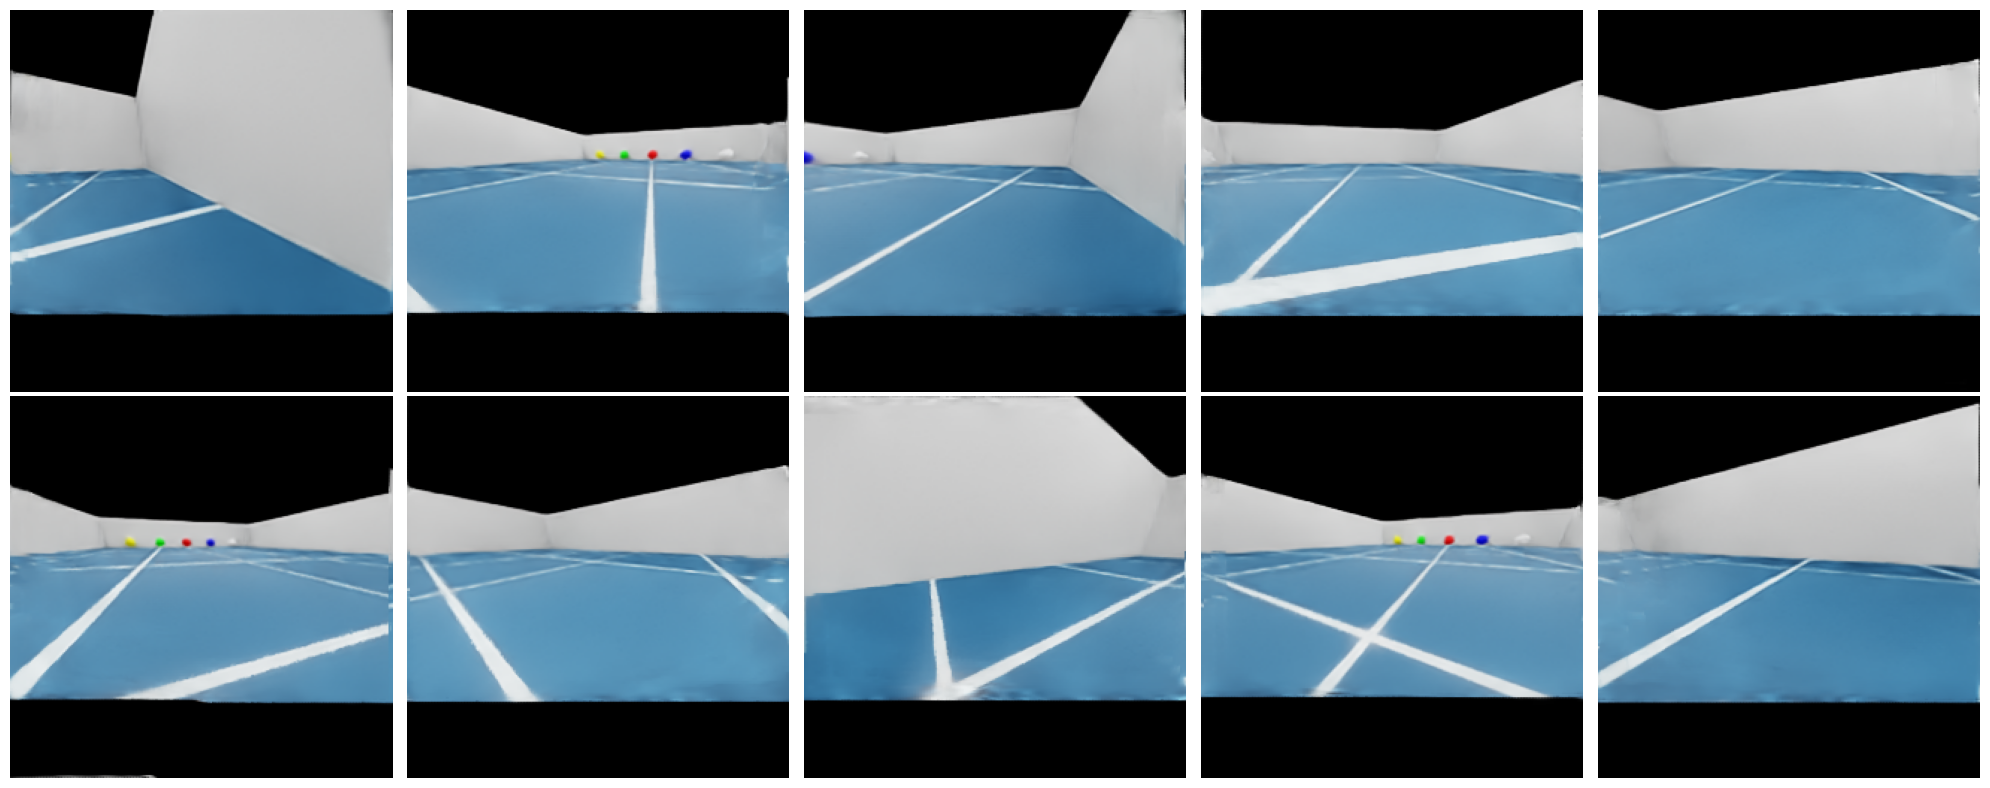

In [5]:
import matplotlib.pyplot as plt
import torch

# Create a 2-row, 5-column figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # wider and taller

# Flatten axes for easier looping
axes = axes.flatten()

for i in range(10):
    # Get the i-th RGB image
    img = sample.observations["rgb"][i]
    
    # If it's a PyTorch tensor, move to CPU and numpy
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    
    # Change from (C, H, W) -> (H, W, C)
    img = img.transpose(1, 2, 0)

    # Plot on the corresponding subplot
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis for cleaner look

plt.tight_layout()
plt.show()

In [6]:
import cv2, numpy as np


def grid_cell(cx, cy, W, H):
    col = "left"   if cx <  W/3 else "centre" if cx < 2*W/3 else "right"
    row = "top"    if cy <  H/3 else "middle" if cy < 2*H/3 else "bottom"
    # massage “middle-centre” → “centre”
    return (f"{row}-{col}"
            .replace("middle-centre", "centre")
            .replace("middle-", "")
            .replace("-centre", ""))


def detect_balls(img, threshold=30):
    """
    Detect balls, draw boxes, *and* return a list of detections.
    Returns
        drawn_img  – RGB image with boxes/labels (uint8)
        det_list   – [(colour, (x,y,w,h), grid_label), …]
    """
    COLOR_CENTRES = {
        'blue'  : np.array([5,   5, 192]),
        'yellow': np.array([212,212, 22]),
        'green' : np.array([22, 214, 21]),
        'red'   : np.array([196, 15, 13])
    }

    out  = img.copy()
    H, W = img.shape[:2]
    dets = []

    for colour, centre in COLOR_CENTRES.items():
        lo = np.clip(centre - threshold, 0, 255)
        hi = np.clip(centre + threshold, 0, 255)

        mask, *_ = cv2.inRange(img, lo, hi),   # binary mask
        cnts, _  = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)

        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            if w * h < 10:
                continue
            # draw
            cv2.rectangle(out, (x, y), (x+w, y+h), (0,255,0), 2)
            (tw, th), _ = cv2.getTextSize(colour, cv2.FONT_HERSHEY_SIMPLEX, .5, 1)
            cv2.rectangle(out, (x, y-th-6), (x+tw, y), (0,0,0), -1)
            cv2.putText(out, colour, (x, y-2), cv2.FONT_HERSHEY_SIMPLEX, .5,
                        (255,255,255), 1)

            cx, cy = x + w//2, y + h//2
            dets.append((colour, (x, y, w, h), grid_cell(cx, cy, W, H)))

    return out, dets

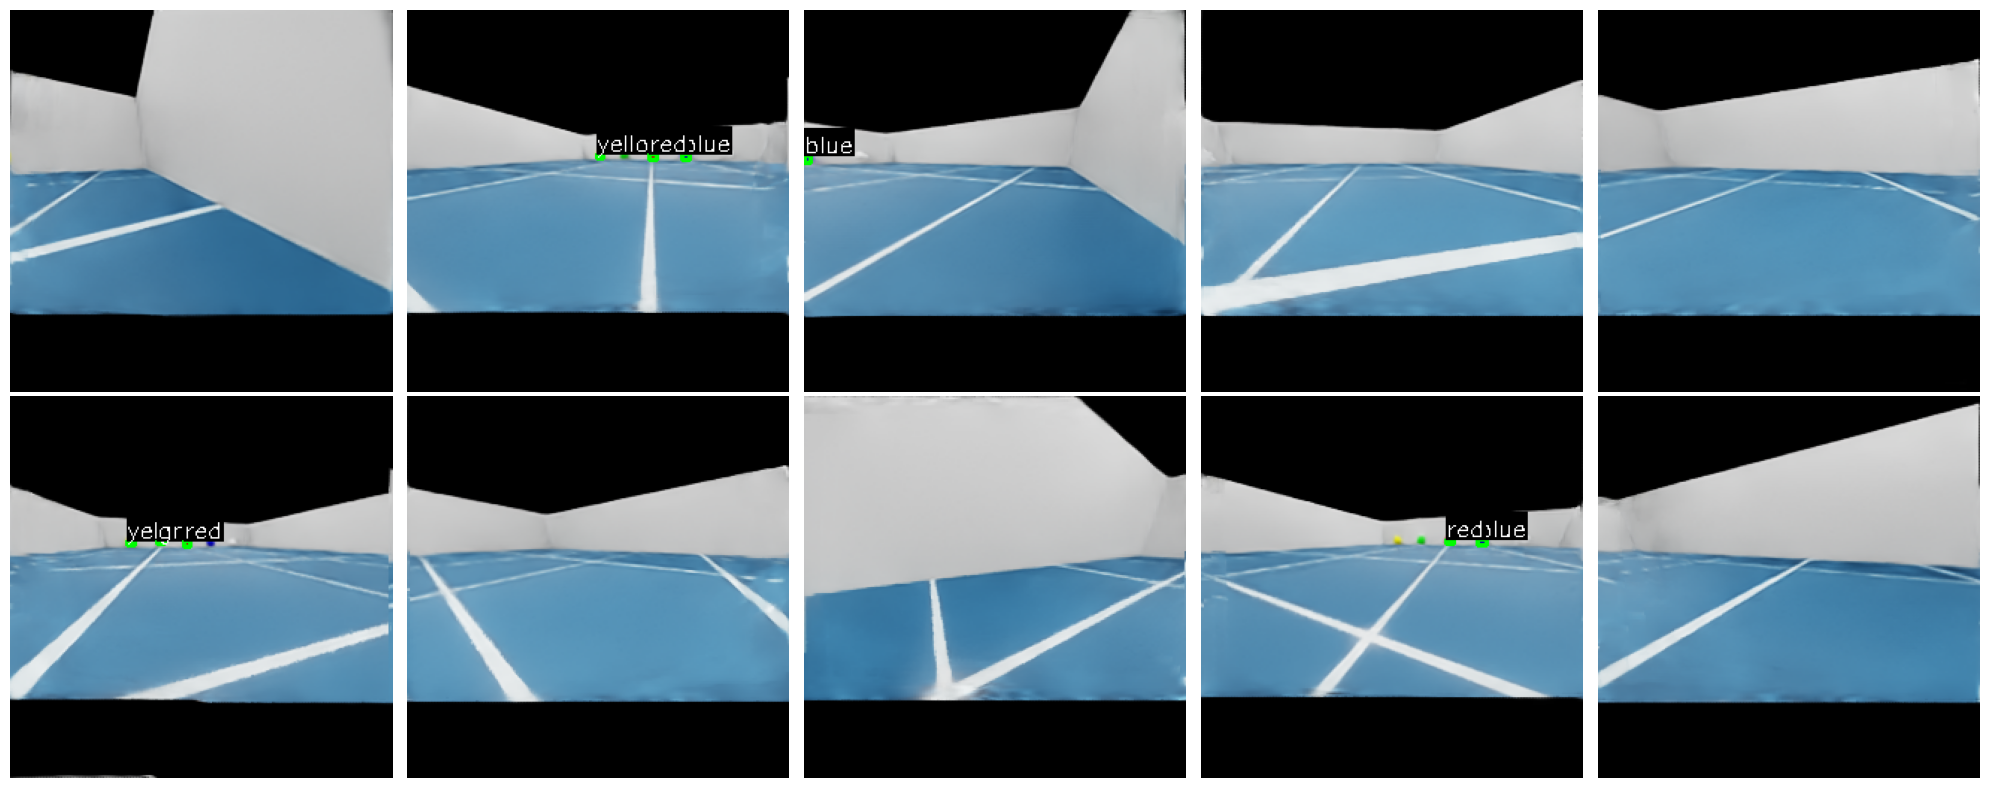

In [7]:
import matplotlib.pyplot as plt, torch, numpy as np

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

tasks_dict = {}                                  # ← the object you asked for

for i in range(N):
    img = sample.observations["rgb"][i]
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    img = img.transpose(1, 2, 0)                 # CHW → HWC
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    if img.shape[-1] == 4:
        img = img[..., :3]

    vis_img, dets = detect_balls(img)            # ← new return value

    # save tasks for this frame
    tasks_dict[i] = [
        {"task": f"Go to the {colour} ball", "location": loc}
        for colour, _, loc in dets
    ]
    if i < 10:
        # show detections as before
        axes[i].imshow(vis_img)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
tasks_dict

{0: [],
 1: [{'task': 'Go to the blue ball', 'location': 'right'},
  {'task': 'Go to the yellow ball', 'location': 'centre'},
  {'task': 'Go to the red ball', 'location': 'centre'}],
 2: [{'task': 'Go to the blue ball', 'location': 'left'}],
 3: [],
 4: [],
 5: [{'task': 'Go to the yellow ball', 'location': 'left'},
  {'task': 'Go to the green ball', 'location': 'centre'},
  {'task': 'Go to the red ball', 'location': 'centre'}],
 6: [],
 7: [],
 8: [{'task': 'Go to the blue ball', 'location': 'right'},
  {'task': 'Go to the red ball', 'location': 'centre'}],
 9: [],
 10: [],
 11: [{'task': 'Go to the blue ball', 'location': 'left'},
  {'task': 'Go to the red ball', 'location': 'left'}],
 12: [{'task': 'Go to the blue ball', 'location': 'centre'},
  {'task': 'Go to the yellow ball', 'location': 'left'},
  {'task': 'Go to the green ball', 'location': 'centre'}],
 13: [],
 14: [],
 15: [{'task': 'Go to the yellow ball', 'location': 'right'},
  {'task': 'Go to the green ball', 'location': 

In [9]:
import warnings, torch, numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import transformers                        # just to silence logs

transformers.logging.set_verbosity_error()

# ────────────────────────────────────────────────────────────────────────────────
class CLIPMatcher:
    """
    Creates a *joint* image-text embedding by
        joint = normalize( image_emb + text_emb )
    for every prompt supplied.
    """

    def __init__(self,
                 model_name: str = "openai/clip-vit-base-patch32",
                 device: str | None = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading CLIP model ({model_name}) on {self.device}…")

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.processor = CLIPProcessor.from_pretrained(model_name)
            self.model     = (CLIPModel.from_pretrained(model_name)
                              .to(self.device)
                              .eval())

    # ----------------------------------------------------------------------
    @staticmethod
    def _l2_normalize(x: torch.Tensor) -> torch.Tensor:
        """Row-wise L2-normalize."""
        return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    # ----------------------------------------------------------------------
    @torch.no_grad()
    def get_joint_embeddings(self, image: Image.Image, prompts: list[str]) -> np.ndarray:
        """
        Parameters
        ----------
        image   : PIL.Image
        prompts : list[str]

        Returns
        -------
        np.ndarray  shape = (len(prompts), hidden_dim)   (float32)
        """
        # ---- 1. Image embedding (done once per frame) --------------------
        img_inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        img_feat   = self._l2_normalize(self.model.get_image_features(**img_inputs))  # [1, D]

        # ---- 2. Text embeddings (batch − much faster) --------------------
        txt_inputs = self.processor(text=prompts, return_tensors="pt",
                                    padding=True).to(self.device)
        txt_feat   = self._l2_normalize(self.model.get_text_features(**txt_inputs))   # [N, D]

        # ---- 3. Fuse: image + text → joint vector ------------------------
        joint = self._l2_normalize(img_feat + txt_feat)                               # [N, D]

        return joint.cpu().numpy().copy()        # copy = own memory for later
# ────────────────────────────────────────────────────────────────────────────────


In [10]:
import torch, numpy as np, warnings
from PIL import Image
from transformers import ViltProcessor, ViltModel

class VILTMash:
    def __init__(self, ckpt="dandelin/vilt-b32-finetuned-vqa", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.proc  = ViltProcessor.from_pretrained(ckpt)
            self.model = ViltModel.from_pretrained(ckpt).to(self.device).eval()

    @torch.no_grad()
    def get_joint_embeddings(self, image: Image.Image, prompts: list[str]) -> np.ndarray:
        if not prompts:
            return np.empty((0, self.model.config.hidden_size), np.float32)

        batch = self.proc(text=prompts,
                          images=[image]*len(prompts),
                          return_tensors="pt",
                          padding=True).to(self.device)

        out   = self.model(**batch)
        joint = out.pooler_output          # [N, hidden_dim] → CLS after fusion
        return joint.cpu().numpy().copy()


In [15]:
from transformers import SiglipProcessor, SiglipModel        # new imports


class SigLIPMatcher:
    def __init__(self,
                 ckpt="google/siglip-so400m-patch14-384",
                 device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.proc   = SiglipProcessor.from_pretrained(ckpt)
        self.model  = SiglipModel.from_pretrained(ckpt).to(self.device).eval()

    @staticmethod
    def _l2(x):          # row-wise normalisation
        return x / x.norm(dim=-1, keepdim=True).clamp(min=1e-6)

    @torch.no_grad()
    def get_joint_embeddings(self, image: Image.Image,
                             prompts: list[str]) -> np.ndarray:
        if not prompts:
            h = self.model.config.projection_dim
            return np.empty((0, h), dtype=np.float32)

        # 1) IMAGE → GPU *before* forward
        img_inp = self.proc(images=image, return_tensors="pt").to(self.device)
        img_feat = self._l2(self.model.get_image_features(**img_inp))          # [1, D]

        # 2) TEXT  → GPU *before* forward
        txt_inp = self.proc(text=prompts, return_tensors="pt",
                            padding=True).to(self.device)
        txt_feat = self._l2(self.model.get_text_features(**txt_inp))           # [N, D]

        # 3) Fusion
        joint = self._l2(img_feat + txt_feat)                                  # [N, D]
        return joint.cpu().numpy().copy()



In [16]:
#matcher = CLIPMatcher()                         
#matcher = VILTMash()
matcher = SigLIPMatcher()

for img_id, task_list in tqdm(tasks_dict.items(), desc="Processing images"):
    img_np = sample.observations["rgb"][img_id]
    if isinstance(img_np, torch.Tensor):
        img_np = img_np.cpu().numpy()
    img_np = img_np.transpose(1, 2, 0).astype(np.uint8)
    if img_np.shape[-1] == 4:
        img_np = img_np[..., :3]
    img_pil = Image.fromarray(img_np)

    prompts = [t["task"] for t in task_list]
    if not prompts:          # no prompts → nothing to compute
        continue
    embs = matcher.get_joint_embeddings(img_pil, prompts)


    for t, e in zip(task_list, embs):
        t["embedding"] = e          # now CLIP-based joint embeddings


Processing images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:46<00:00, 24.60it/s]


In [17]:
import random, itertools, numpy as np
from scipy.spatial.distance import cosine

# ------------------------------------------------------------------
def evaluate_pairs(tasks_dict, N=None, rng=None, verbose=False):
    """
    Randomly sample up to N unordered image pairs from `tasks_dict`,
    compute cosine distance between matching-colour prompts,
    and return summary stats.
    
    Returns
    -------
    results : dict
        {
          "same" : list[float],      # distances where location matches
          "diff" : list[float],      # distances where location differs
          "pairs_evaluated" : int,   # ⩽ N
          "pairs_skipped"   : int    # no common colour → skipped
        }
    """
    rng = rng or random.Random()                  # allows seeding

    img_ids      = list(tasks_dict.keys())
    all_pairs    = list(itertools.combinations(img_ids, 2))
    rng.shuffle(all_pairs)                        # in-place
    
    if N is not None:
        sample_pairs = all_pairs[:N]                  # ⩽ N (or fewer if dataset small)
    else:
        sample_pairs = all_pairs

    same_loc_d, diff_loc_d = [], []
    skipped = 0

    for img_a, img_b in sample_pairs:
        # ---- quick look-ups colour → (location, embedding)
        look = {}
        for img_id, store in ((img_a, tasks_dict[img_a]),
                              (img_b, tasks_dict[img_b])):
            look[img_id] = { t["task"].split()[3] : (t["location"], t["embedding"])
                             for t in store }

        common = set(look[img_a]) & set(look[img_b])
        if not common:
            skipped += 1
            continue

        for colour in common:
            loc_a, emb_a = look[img_a][colour]
            loc_b, emb_b = look[img_b][colour]
            d = cosine(emb_a, emb_b)

            (same_loc_d if loc_a == loc_b else diff_loc_d).append(d)

        if verbose:
            print(f"Pair {img_a}–{img_b}: +{len(common)} comparisons")

    return {
        "same"            : same_loc_d,
        "diff"            : diff_loc_d,
        "pairs_evaluated" : len(sample_pairs) - skipped,
        "pairs_skipped"   : skipped
    }

# ------------------------------------------------------------------
def print_report(res):
    same, diff = res["same"], res["diff"]
    fmt = lambda xs: f"n={len(xs):<4} | μ={np.mean(xs):.4f} | σ={np.std(xs):.4f}" if xs else "–"
    print("\nRESULTS ACROSS RANDOM PAIRS")
    print("Same spatial cell : ", fmt(same))
    print("Different cell    : ", fmt(diff))
    print(f"Pairs evaluated   : {res['pairs_evaluated']}")
    print(f"Pairs skipped     : {res['pairs_skipped']} (no shared colour)")

In [18]:
res = evaluate_pairs(tasks_dict, N=400000, rng=random.Random(42))
print_report(res)


RESULTS ACROSS RANDOM PAIRS
Same spatial cell :  n=51465 | μ=0.0245 | σ=0.0118
Different cell    :  n=97191 | μ=0.0310 | σ=0.0145
Pairs evaluated   : 70320
Pairs skipped     : 329680 (no shared colour)


In [ ]:
'''
VLM: clip-vit-base-patch32

Samples: 10000
RESULTS ACROSS RANDOM PAIRS
Same spatial cell :  n=51890 | μ=0.0276 | σ=0.0130
Different cell    :  n=99391 | μ=0.0312 | σ=0.0144
Pairs evaluated   : 71837
Pairs skipped     : 328163 (no shared colour)


VLM: dandelin/vilt-b32-finetuned-vqa

Samples: 10000
RESULTS ACROSS RANDOM PAIRS
Same spatial cell :  n=51890 | μ=0.0380 | σ=0.0374
Different cell    :  n=99391 | μ=0.0442 | σ=0.0447
Pairs evaluated   : 71837
Pairs skipped     : 328163 (no shared colour)


VLM: google/siglip-so400m-patch14-384

Samples: 10000
RESULTS ACROSS RANDOM PAIRS
Same spatial cell :  n=51465 | μ=0.0245 | σ=0.0118
Different cell    :  n=97191 | μ=0.0310 | σ=0.0145
Pairs evaluated   : 70320
Pairs skipped     : 329680 (no shared colour)


'''

'\nVLM: BLIP-2\nSamples: 100\n'

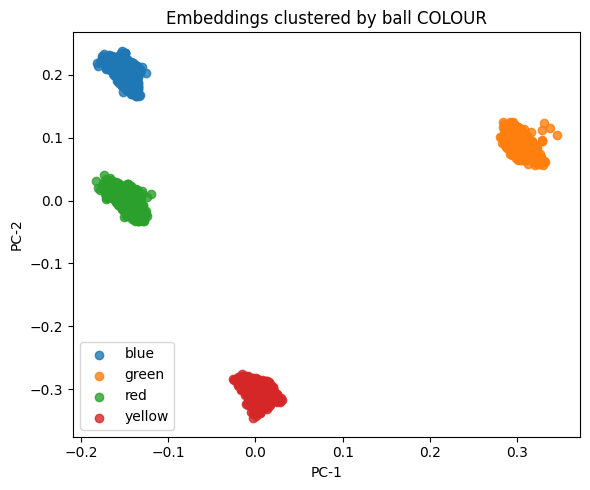

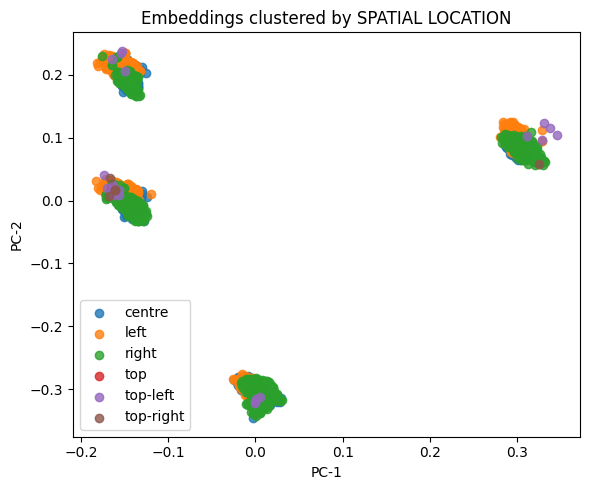

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_embeddings(tasks_dict):
    """Project embeddings to 2‑D and plot clusters."""

    embs, colour_labels, loc_labels = [], [], []

    for task_list in tasks_dict.values():
        for entry in task_list:
            embs.append(entry["embedding"])
            # prompt = "Go to the <colour> ball"  → index 3 is the colour
            colour_labels.append(entry["task"].split()[3])
            loc_labels.append(entry["location"])

    embs = np.stack(embs)  # shape (N, D)

    reducer = PCA(n_components=2)
    coords2d = reducer.fit_transform(embs)

    def scatter_by(labels, title):
        plt.figure(figsize=(6, 5))
        for lab in sorted(set(labels)):
            idx = [i for i, l in enumerate(labels) if l == lab]
            plt.scatter(coords2d[idx, 0], coords2d[idx, 1], label=lab, alpha=0.8)
        plt.title(title)
        plt.xlabel("PC‑1")
        plt.ylabel("PC‑2")
        plt.legend()
        plt.tight_layout()
        plt.show()

    scatter_by(colour_labels, "Embeddings clustered by ball COLOUR")
    scatter_by(loc_labels,   "Embeddings clustered by SPATIAL LOCATION")


plot_embeddings(tasks_dict)  # need to think about the results

